# Stochastic MAT dSTRF crcns fit

This script fits crcns data to a dSTRF model composed of the augmented MAT model and a cosine basis STRF.

In [68]:
from __future__ import print_function, division
import numpy as np
import scipy as sp
import neurofit as nf
import pyspike as pyspk
from scipy.signal import resample

import sys
sys.path.append("../") # for importing utils and glm

import utils
from models import cosstrf, mat, dstrf_mat

from neurofit import utils as nfutils


# plotting packages
%matplotlib inline
from matplotlib.pyplot import * # plotting functions
import seaborn as sns           # data visualization package
sns.set_style("whitegrid")

## Setting paramters and loading data

In [69]:
# assimilation parameters
nwalkers = 1000
burn = 1000
threads = 8
keep = 1
num_assim_stims = 15
tracker = nfutils.convergence_tracker(burn,burn/10)

# dstrf model settings
free_ts = False
scale = 10
channels = 1
ncos = 10
coslin = 100
norm = True
center = True

# data parameters 
nspec = 30
t_dsample = 5
tlen = int(np.rint(150/t_dsample))
psth_smooth = 5/t_dsample
compress = 1

# setup cosine basis
tbas, fromt, tot = utils.cosbasis(tlen,ncos,coslin,retfn=True,norm=True)

# load data from crcns
cell = "oo1220_2_A"
stim_type = "conspecific"

stims,durations,spikes_data,spiky_data = utils.load_crcns(cell,stim_type,nspec,t_dsample,compress)
psth_data = [utils.psth(spk,dur,t_dsample,dsample=t_dsample) for spk,st,dur in zip(spikes_data,stims,durations)]

# separate the simulation and validation sets
assim_psth, test_psth = np.split(psth_data,[num_assim_stims])
assim_spikes, test_spikes = np.split(spikes_data,[num_assim_stims])
assim_spiky, test_spiky = np.split(spiky_data,[num_assim_stims])
assim_stims, test_stims = stims[:num_assim_stims], stims[num_assim_stims:]
assim_dur, test_dur = np.split(durations,[num_assim_stims])

# calculate correlation between even and odd trial psths
eocorr = [utils.evenoddcorr(spks,dur,dsample=t_dsample,smooth=psth_smooth) for spks,dur in zip(spikes_data,durations)]
print("EO: {:.2f}".format(np.mean(eocorr)))

EO: 0.68


## Getting initial guess for STRF

In [70]:
# estimate STRF using elastic net regression
fit_psth = [p*1000 for p in assim_psth]
#fit_psth = [normalize(p,False) for p in assim_psth]

STRF_GUESS, B_GUESS = utils.get_strf(assim_stims,fit_psth,tlen,fit_intercept=False)
SPEC,TIM = utils.factorize(STRF_GUESS,channels)

# create initial paramter vector from estimated strf
filt_start = np.hstack((SPEC,tot(TIM))).flatten()

0.355083772855


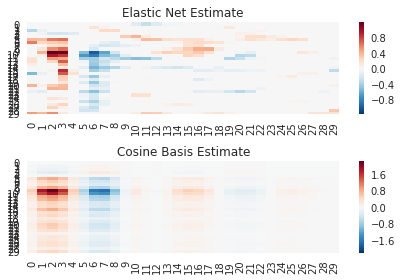

In [71]:
# plot elastic net and cosine estimate
subplot(211)
title("Elastic Net Estimate")
sns.heatmap(STRF_GUESS)

subplot(212)
title("Cosine Basis Estimate")
strf_model = cosstrf(channels,nspec,tlen,ncos,coslin,normalize=norm,center=center)
strf_model.set(filt_start)
sns.heatmap(strf_model.filt)

tight_layout()
print(utils.evaluate(strf_model.filt,test_stims,test_psth))

## Define loss and prior functions

In [72]:
from neurofit import priors
from neurofit import costs

def spike_distance(predict,data):
    trace, spikes = predict
    spiky = pyspk.SpikeTrain(spikes,[0,data[0].t_end])
    dist = 1000*np.mean([pyspk.spike_distance(spiky,trial) for trial in data])
    return dist

mat_prior = priors.joint_independent(
                [ nf.priors.uniform(-1000,  1000),
                  nf.priors.uniform( -100,   100),
                  nf.priors.uniform( -100,   100),
                  nf.priors.uniform( -1000,  1000)])

unbounded = priors.unbounded()

def dstrf_shrink_prior(theta):
    return -np.sum(np.abs(theta[:-4])) + mat_prior(theta[-4:])

def pploss(predict,data):
    lam = predict[0][:,2]
    if np.shape(data[0]) == ():
        data = [data]
    data = [np.rint(d).astype(int) for d in data]
    return -np.sum([np.sum(np.log(lam[d])) - np.sum(lam) for d in data])

cost = spike_distance

## Run initial MAT parameter fit

In [73]:
from neurofit import startpos

# get I with STRF fixed
Iapp = []
for s,dur in zip(stims,durations):
    R = resample(strf_model.run(s),dur)
    Iapp.append(R*scale)
    
assim_Iapp, test_Iapp = np.split(Iapp,[num_assim_stims])

# initalize the mat model
mat_model = mat(free_ts=free_ts,stochastic=True)

# generate starting positions of emcee walkers
#p0 = startpos.uniform_independent(nwalkers,[-100,-10,-10,0],[100,10,10,100])
p0 = startpos.normal_independent(nwalkers,[10,1,0.1,20],[0.1]*4)

# run emcee
mat_smplr = nf.sampler(mat_model,mat_prior,cost,nwalkers,zip(assim_Iapp,assim_spiky),8)
for pos,_,_ in tracker(mat_smplr.sample(p0,iterations=burn)): continue
mat_smplr.reset()
mat_smplr.run_mcmc(pos,1);

  step      lnprob        time         ETA
------------------------------------------
   100     -2845.8     0:01:10     0:10:44
   200       -2789     0:02:20     0:09:23
   300     -2766.4     0:03:29     0:08:11
   400     -2759.1     0:04:38     0:06:59
   500     -2756.5     0:05:46     0:05:48
   600     -2752.5     0:06:55     0:04:38
   700     -2748.6     0:08:03     0:03:28
   800     -2746.2     0:09:13     0:02:19
   900     -2744.9     0:10:21     0:01:09
  1000     -2743.9     0:11:29     0:00:00
  1001     -2743.9     0:11:30     0:00:00


In [74]:
# check the performance of the fit mat model
mml = mat_smplr.flatchain[np.argmax(mat_smplr.flatlnprobability)]
mat_map = mat(stochastic=True)
mat_map.set(mml)
mat_corr = []

param_corr = utils.evaluate(STRF_GUESS,test_stims,test_psth)

for i,p,d in zip(test_Iapp,test_psth,test_dur):
    trace,spikes = mat_map.run(i)
    mat_psth = utils.psth_spiky(pyspk.SpikeTrain(spikes,[0,d]),binres=1,smooth=psth_smooth,dsample=t_dsample)
    mat_corr.append(np.corrcoef(p,mat_psth)[0][1])
        
start = np.hstack((filt_start,mml))
print("Filt R: {:.3f}, MAT R: {:.3f}".format(param_corr,np.mean(mat_corr)))

Filt R: 0.498, MAT R: 0.610


## Fit dSTRF model using emcee

In [75]:
# initalize the model
model = dstrf_mat(1,nspec,tlen,ncos,coslin,t_dsample,scale=scale,normalize=norm,center=center,stochastic=True)

# set starting positions for walkers
p0 = startpos.normal_independent(nwalkers-1,start,[1e-1]*len(start))
p0 = np.vstack((start,p0))

# run emcee
dstrf_smplr = nf.sampler(model,dstrf_shrink_prior,cost,nwalkers,zip(assim_stims,assim_spiky),8)
for pos,_,_ in tracker(dstrf_smplr.sample(p0,iterations=burn)): continue
dstrf_smplr.reset()
dstrf_smplr.run_mcmc(pos,1);

  step      lnprob        time         ETA
------------------------------------------
   100     -2758.8     0:04:38     0:42:11
   200     -2738.7     0:09:17     0:37:22
   300     -2726.5     0:13:54     0:32:37
   400     -2717.3     0:18:33     0:27:57
   500     -2709.5     0:23:11     0:23:16
   600     -2702.2     0:27:48     0:18:37
   700     -2695.2     0:32:28     0:13:58
   800     -2687.6     0:37:06     0:09:20
   900     -2680.2     0:41:44     0:04:41
  1000     -2673.3     0:46:22     0:00:02
  1001     -2673.2     0:46:24     0:00:00


## Evaluate the model fit

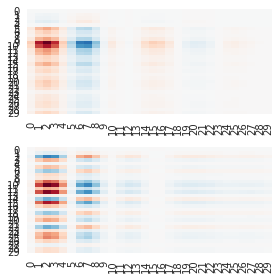

In [76]:
# initalize model with MAP parameter estimate
dmap = dstrf_smplr.flatchain[np.argmax(dstrf_smplr.flatlnprobability)]
model.set(dmap)

figure(figsize=(4,4))

# compare EN and dstrf STRFs
subplot(211)
sns.heatmap(strf_model.filt,cbar=False)

subplot(212)
sns.heatmap(model.pstrf.filt,cbar = False)
tight_layout()

In [77]:
reload(utils)

<module 'utils' from '../utils.pyc'>

In [86]:
map_corr = utils.dstrf_sample_validate(model,dmap,test_stims,test_psth,t_dsample,psth_smooth,figsize=(4,1),ntrials=10)
ppcorr = utils.posterior_predict_corr(model,test_stims,test_psth,dstrf_smplr.flatchain,t_dsample,psth_smooth)
corr_means = np.mean([map_corr,ppcorr,eocorr[num_assim_stims:]],axis=1)
print("\nMAP: {:.2f}, Dist: {:.2f}, EO: {:.2f}".format(corr_means[0],corr_means[1],corr_means[2]))
print("MAP/EO: {:.2f}, Dist/EO: {:.2f}".format(corr_means[0]/corr_means[2],corr_means[1]/corr_means[2]))


MAP: 0.70, Dist: 0.70, EO: 0.64
MAP/EO: 1.09, Dist/EO: 1.09


In [81]:
dmap

array([  0.04038838,  -0.12519078,  -0.75160433,   0.38875195,
        -0.03862148,   0.33170395,  -0.41975861,   0.22390845,
         0.16223792,   0.67983806,   1.10601295,   0.41344196,
         1.02699385,   0.09693488,  -0.53952148,   0.908512  ,
         0.31823975,  -0.05344782,  -0.42906503,   0.22801682,
         0.43749203,  -0.05657257,  -0.53815481,   0.17312653,
         0.48562635,   0.55048508,   0.24821063,  -0.06178387,
         0.18591213,   0.19819244,  -4.29440638,   8.94366775,
        -6.10719091,   1.93982654,  -1.23759651,   0.06180931,
         0.29318126,  -0.76930586,   0.22052564,  -0.37224157,
        11.11614048,   9.96810133,  -2.01406363,  23.17594419])